In [1]:
import os
os.chdir("../..")

In [2]:
import omegaconf
from shell.utils.experiment_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from shell.fleet.fleet import Agent
from shell.fleet.data.send_utilize import *
from shell.fleet.data.recv import *

import logging
logging.basicConfig(level=logging.DEBUG)

In [3]:
save_root_dir = "vanilla_remove_datasets_hack_results"
dataset = "mnist"
algo = "modular"
num_train = 64
seed = 0
use_contrastive = True

In [4]:
job_name = f"{dataset}_{algo}_numtrain_{num_train}"
if use_contrastive:
    job_name += "_contrastive"
experiment = os.path.join(save_root_dir, job_name, dataset,algo, f"seed_{seed}")

In [5]:
config_path = os.path.join(experiment, "hydra_out", ".hydra", "config.yaml")
# read the config file
cfg = omegaconf.OmegaConf.load(config_path)
cfg

{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 1}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'vanilla_remove_datasets_hack_results', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}

In [6]:
graph, datasets, NetCls, LearnerCls, net_cfg, agent_cfg, train_cfg, fleet_additional_cfg = setup_experiment(cfg)
len(datasets)

INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 1}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'vanilla_remove_datasets_hack_results', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


8

In [7]:
task_id = 3
num_added_components = None
receiver_id = 0
sender_id = 2

In [8]:
cfg.sharing_strategy.name = "recv_data"
cfg.sharing_strategy.num_coms_per_round = 2
cfg.sharing_strategy.num_queries = 10
cfg.sharing_strategy.num_data_neighbors = 5
cfg.sharing_strategy.scorer = "cross_entropy"
cfg.sharing_strategy.query_score_threshold = 0.6931471805599453

In [9]:
receiver = RecvDataAgent(receiver_id, seed, datasets[receiver_id],
                NetCls, LearnerCls, net_cfg, agent_cfg, train_cfg, 
                cfg.sharing_strategy)

sender = RecvDataAgent(sender_id, seed, datasets[sender_id],
                NetCls, LearnerCls, net_cfg, agent_cfg, train_cfg, 
                cfg.sharing_strategy)

INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 2, seed: 2000


In [10]:
receiver.net = load_net(cfg, NetCls, net_cfg, agent_id=receiver_id, task_id=task_id, num_added_components=num_added_components)
receiver.net

MLPSoftLLDynamic(
  (structure): ParameterList(
      (0): Parameter containing: [torch.float32 of size 4x4 (GPU 0)]
      (1): Parameter containing: [torch.float32 of size 4x4 (GPU 0)]
      (2): Parameter containing: [torch.float32 of size 4x4 (GPU 0)]
      (3): Parameter containing: [torch.float32 of size 4x4 (GPU 0)]
      (4): Parameter containing: [torch.float32 of size 4x4 (GPU 0)]
      (5): Parameter containing: [torch.float32 of size 4x4 (GPU 0)]
      (6): Parameter containing: [torch.float32 of size 4x4 (GPU 0)]
      (7): Parameter containing: [torch.float32 of size 4x4 (GPU 0)]
      (8): Parameter containing: [torch.float32 of size 4x4 (GPU 0)]
      (9): Parameter containing: [torch.float32 of size 4x4 (GPU 0)]
  )
  (softmax): Softmax(dim=0)
  (components): ModuleList(
    (0-3): 4 x Linear(in_features=64, out_features=64, bias=True)
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.0, inplace=False)
  (random_linear_projection): Linear(in_features=784, out_features=64, b

In [11]:
testloaders = {task: torch.utils.data.DataLoader(testset,
                                                         batch_size=128,
                                                         shuffle=False,
                                                         num_workers=0,
                                                         pin_memory=True,
                                                         ) for task, testset in enumerate(datasets[receiver_id].testset[:(task_id+1)])}
eval_net(receiver.net, testloaders)

{0: 0.9668803418803419,
 1: 0.9844377510040161,
 2: 0.9788659793814433,
 3: 0.9799196787148594,
 'avg': 0.9775259377451653}

In [12]:
X_queries, y_queries, y_pred_queries, score_queries = receiver.compute_query(task_id=3, mode="all", debug_return=True)

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vlongle/miniconda3/envs/shell/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vlongle/miniconda3/envs/shell/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vlongle/mini

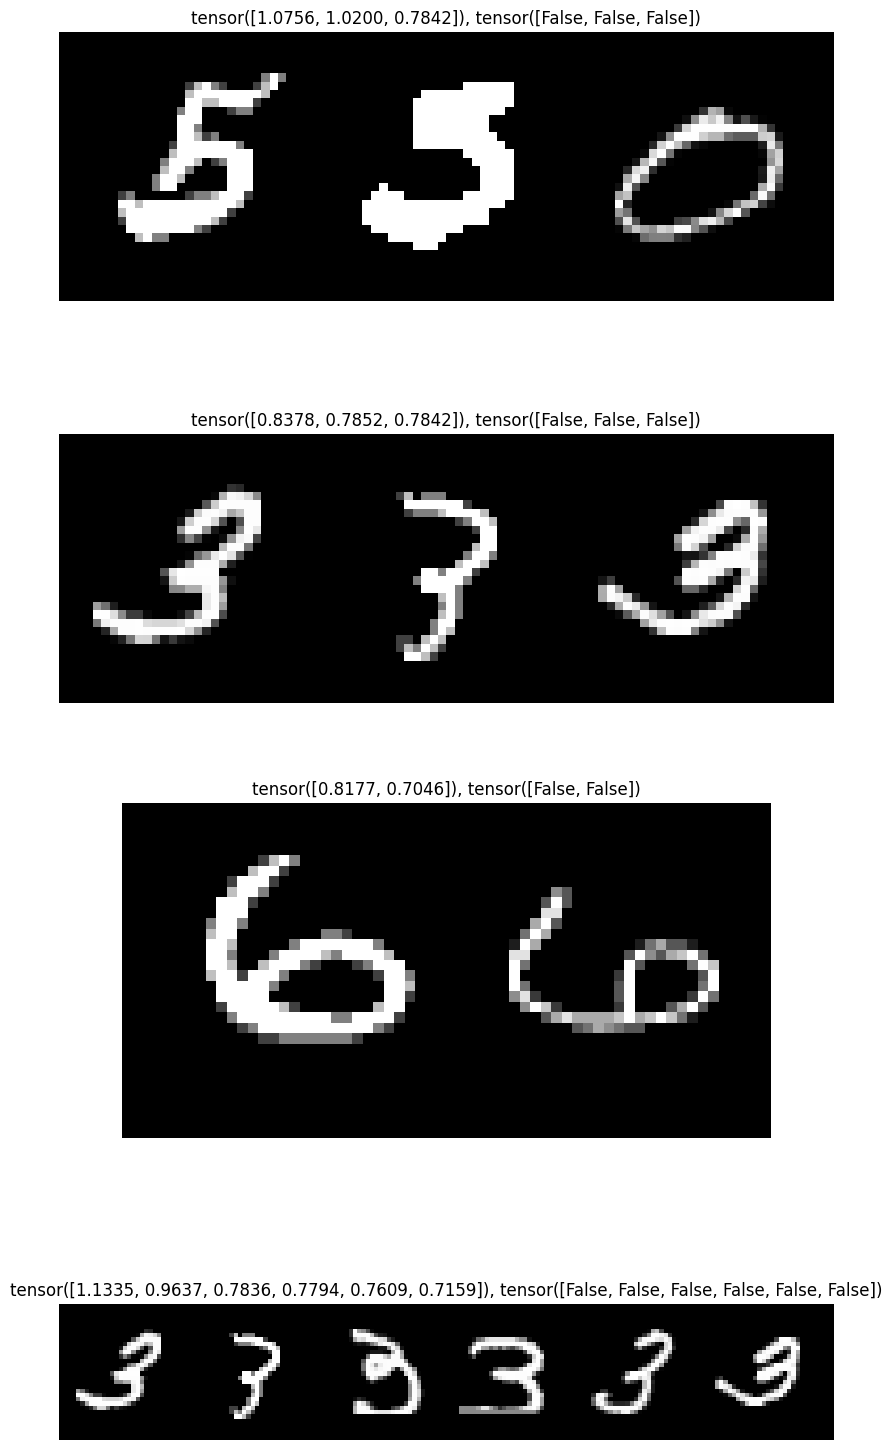

In [13]:
# visualize the queries using plt.imshow and make_grid
fig, axs = plt.subplots(len(X_queries), 1, figsize=(10, 20))

# correct is when y_queries == y_pred_queries
for t in range(len(X_queries)):
    X = X_queries[t]
    y_q = y_queries[t]
    y_p = y_pred_queries[t]
    correct = y_q == y_p
    from torchvision.utils import make_grid
    X = make_grid(X)
    axs[t].imshow(X.permute(1, 2, 0))
    axs[t].set_title(f"{score_queries[t]}, {correct}")
    axs[t].axis("off")


In [14]:
correct

tensor([False, False, False, False, False, False])

In [15]:
type(receiver.dataset.valset[0].tensors[0].cpu())

torch.Tensor

In [16]:
np.log(1/2)

-0.6931471805599453

In [17]:
for t in range(task_id+1):
    trainloader = torch.utils.data.DataLoader(receiver.dataset.trainset[t],
                                                            batch_size=128,
                                                            shuffle=True,
                                                            num_workers=0,
                                                            pin_memory=True,
                                                            )
    sender.agent.update_multitask_cost(trainloader, t)

sender.agent.replay_buffers

{0: <shell.utils.replay_buffers.ReplayBufferReservoir at 0x7f7ecbb00c70>,
 1: <shell.utils.replay_buffers.ReplayBufferReservoir at 0x7f7ecbcb5d80>,
 2: <shell.utils.replay_buffers.ReplayBufferReservoir at 0x7f7ecbcb5f60>,
 3: <shell.utils.replay_buffers.ReplayBufferReservoir at 0x7f7ecbca3250>}

In [18]:
sender.compute_ball()
sender.nearest_neighbors(X, n_neighbors=10)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)